In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from bisect import bisect
from scipy.sparse import csr_matrix
import scipy.sparse as sparse

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
import utils
from OLP.Code import OLP

In [4]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# CLASSIFIER PARAMETERS
ratio = 0.333                                               # data splitting ratio is 1/3
quality_class_intervals = [0, 0.25, 0.50, 0.75, 1.001]      # quality class intervals
quality_class_labels = [0, 1, 2, 3]                         # quality class labels
quality_class_names = ['exelent', 'good', 'ok', 'poor']     # quality classes names

# Step 1
## Graph generation / importing


In [5]:
import pickle  
# load the data 
infile = open('OLP/Benchmark/OLP_updated.pickle','rb')  
df = pickle.load(infile)  

In [6]:
df = df.sort_values(by=['number_edges'], ascending=False)
df['number_edges'].head(5)

123    7562.0
13     5648.0
41     5451.0
542    4916.0
544    4831.0
Name: number_edges, dtype: float64

In [7]:
df_edgelists = df['edges_id']
edges_orig = df_edgelists.iloc[0]

# Step 2
## Feature calculation

In [8]:
edges_orig = np.array(np.matrix(edges_orig))
num_nodes = int(np.max(edges_orig)) + 1
row = np.array(edges_orig)[:,0]
col = np.array(edges_orig)[:,1]

data_aux = np.ones(len(row))
A_orig = csr_matrix((data_aux,(row,col)),shape=(num_nodes,num_nodes))
A_orig = sparse.triu(A_orig,1) + sparse.triu(A_orig,1).transpose()
A_orig[A_orig>0] = 1 
A_orig = A_orig.todense()

#### construct the holdout and training matriced from the original matrix
alpha = 0.8 # sampling rate for holdout matrix
alpha_ = 0.8 # sampling rate for training matrix
A_ho, A_tr = OLP.gen_tr_ho_networks(A_orig, alpha, alpha_)

 #### extract features #####
OLP.sample_true_false_edges(A_orig, A_tr, A_ho)
edge_t_tr = np.loadtxt("./edge_tf_tr/edge_t.txt").astype('int')
edge_f_tr = np.loadtxt("./edge_tf_tr/edge_f.txt").astype('int')
df_f_tr = OLP.gen_topol_feats(A_orig, A_tr, edge_f_tr)
df_t_tr = OLP.gen_topol_feats(A_orig, A_tr, edge_t_tr)

#### load dataframes for train and holdout sets ####
df_tr = OLP.creat_full_set(df_t_tr,df_f_tr)

In [9]:
df_tr.head()

,i,j,TP,com_ne,ave_deg_net,var_deg_net,ave_clust_net,num_triangles_1,num_triangles_2,page_rank_pers_edges,...,short_path,deg_assort,transit_net,diam_net,num_nodes,num_edges,ind,jacc_coeff,res_alloc_ind,adam_adar
0,79,183,1,6,32.794613,20.403901,0.377727,409,119,0.002136,...,2,0.475716,0.393879,6,297,4870,0,0.092308,0.118300,1.521587
1,71,248,1,8,32.794613,20.403901,0.377727,78,65,0.005117,...,2,0.475716,0.393879,6,297,4870,1,0.320000,0.327697,2.490554
2,116,160,1,12,32.794613,20.403901,0.377727,898,199,0.002351,...,2,0.475716,0.393879,6,297,4870,2,0.142857,0.194915,2.910380
3,125,160,1,17,32.794613,20.403901,0.377727,831,199,0.002591,...,2,0.475716,0.393879,6,297,4870,3,0.232877,0.280187,4.138130
4,184,188,1,12,32.794613,20.403901,0.377727,89,93,0.004729,...,2,0.475716,0.393879,6,297,4870,4,0.342857,0.349997,3.372966


In [30]:
feature_names = ['com_ne', 'short_path', 'LHN', 'page_rank_pers_edges', 'pref_attach', 'jacc_coeff', 'adam_adar', 'res_alloc_ind', 'svd_edges', 'svd_edges_dot', 'svd_edges_mean']

ground_truth_df = df_tr[['i', 'j', 'TP'] + feature_names]
ground_truth_df = ground_truth_df.rename(columns={'i': 'node1', 'j': 'node2', 'TP': 'goal'})

ground_truth_df.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,79,183,1,6,2,0.005217,0.002136,1150,0.092308,1.521587,0.118300,-2.914335e-16,6.0,0.240000
1,71,248,1,8,2,0.029630,0.005117,270,0.320000,2.490554,0.327697,-5.551115e-17,8.0,0.533333
2,116,160,1,12,2,0.006176,0.002351,1943,0.142857,2.910380,0.194915,6.349088e-16,12.0,0.413793
3,125,160,1,17,2,0.009610,0.002591,1769,0.232877,4.138130,0.280187,1.873501e-16,17.0,0.586207
4,184,188,1,12,2,0.021978,0.004729,546,0.342857,3.372966,0.349997,9.159340e-16,12.0,0.461538


In [31]:
ground_truth_df['goal'].value_counts()

0    8762
1    1182
Name: goal, dtype: int64

In [32]:
n = np.min(ground_truth_df['goal'].value_counts())

In [33]:
ground_truth_df = ground_truth_df[['node1', 'node2', 'goal']]

ground_truth_df0 = ground_truth_df[ground_truth_df['goal'] == 0].sample(n)
ground_truth_df1 = ground_truth_df[ground_truth_df['goal'] == 1].sample(n)

ground_truth_df = pd.concat([ground_truth_df0, ground_truth_df1])

In [34]:
features_df = ground_truth_df[['node1', 'node2']].merge(
    df_tr[['i', 'j'] + feature_names].rename(columns={'i': 'node1', 'j': 'node2'}),
    how='inner'
)

# normalize
f_to_norm = ['com_ne', 'short_path', 'pref_attach', 'svd_edges_dot']
features_df[f_to_norm] = (features_df[f_to_norm]-features_df[f_to_norm].min())/(features_df[f_to_norm].max()-features_df[f_to_norm].min())

features_df.head(5)

,node1,node2,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,2,100,0.039216,0.000000,0.004566,0.005291,0.075560,0.025974,0.492617,0.034706,4.163336e-16,3.921569e-02,2.739726e-02
1,106,180,0.156863,0.000000,0.003226,0.002359,0.430259,0.085106,2.025963,0.155728,-5.752343e-15,1.568627e-01,2.000000e-01
2,190,205,0.098039,0.000000,0.003524,0.002018,0.245961,0.070423,1.208513,0.080436,-9.922618e-16,9.803922e-02,1.515152e-01
3,58,222,0.000000,0.333333,0.000000,0.001232,0.170401,0.000000,0.000000,0.000000,-1.762479e-15,3.288091e-15,-1.985933e-15
4,11,132,0.058824,0.000000,0.001722,0.003693,0.302067,0.033333,0.705289,0.042782,-3.469447e-16,5.882353e-02,4.477612e-02


# Step 3
## Splitting the data

We split the data in the following way:
* 1/3 is used to train a link prediction model
* 1/3 is used to test the link prediction model. Here we also calculate the error and use this data to train quality classifier
* 1/3 is used to evaluate the clasifier

In [35]:
link_prediction_train = pd.concat([
    ground_truth_df0.sample(int(len(ground_truth_df0) * ratio)), 
    ground_truth_df1.sample(int(len(ground_truth_df1) * ratio))
])

remainder = pd.concat([ground_truth_df, link_prediction_train, link_prediction_train]).drop_duplicates(keep=False)

link_prediction_test = pd.concat([
    remainder[remainder['goal'] == 0].sample(int(len(ground_truth_df0) * ratio)), 
    remainder[remainder['goal'] == 1].sample(int(len(ground_truth_df0) * ratio))
])

remainder = pd.concat([ground_truth_df, link_prediction_test, link_prediction_test]).drop_duplicates(keep=False)

classifier_test = pd.concat([
    remainder[remainder['goal'] == 0].sample(int(len(ground_truth_df0) * ratio)), 
    remainder[remainder['goal'] == 1].sample(int(len(ground_truth_df0) * ratio))
])

link_prediction_train = link_prediction_train[['node1', 'node2', 'goal']].merge(features_df, how='inner', on=['node1', 'node2'])
link_prediction_test = link_prediction_test[['node1', 'node2', 'goal']].merge(features_df, how='inner', on=['node1', 'node2'])
classifier_test = classifier_test[['node1', 'node2', 'goal']].merge(features_df, how='inner', on=['node1', 'node2'])

In [36]:
link_prediction_train['goal'].value_counts()

1    393
0    393
Name: goal, dtype: int64

In [37]:
link_prediction_test['goal'].value_counts()

1    393
0    393
Name: goal, dtype: int64

In [38]:
classifier_test['goal'].value_counts()

1    393
0    393
Name: goal, dtype: int64

# Step 4
## Link prediction model

In [39]:
# LINK PREDICTION BASED ON THE TOPOLOGICAL FEATURES

from sklearn.ensemble import RandomForestClassifier

# random forest classification
forest = RandomForestClassifier(random_state=seed)
forest.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

# predicting edge existace on features
prob = forest.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,20,22,0,0.039216,0.000000,0.013889,0.005039,0.024492,0.090909,0.847707,0.192857,6.661338e-16,3.921569e-02,1.666667e-01,0.00
1,160,247,0,0.000000,0.333333,0.000000,0.001361,0.125413,0.000000,0.000000,0.000000,1.873501e-16,6.071414e-15,-3.304388e-16,0.00
2,16,170,0,0.000000,0.333333,0.000000,0.000427,0.016675,0.000000,0.000000,0.000000,-3.955170e-16,6.442785e-15,-9.907199e-17,0.00
3,33,148,0,0.333333,0.000000,0.007463,0.005600,0.395171,0.202381,4.148473,0.283127,1.339207e-15,3.333333e-01,2.537313e-01,0.00
4,123,244,0,0.000000,0.666667,0.000000,0.000061,0.021365,0.000000,0.000000,0.000000,3.469447e-17,6.445416e-15,-2.931683e-16,0.24


In [40]:
print(f'Accuracy score on {len(link_prediction_test)} test samples:')
print(forest.score(link_prediction_test[feature_names], link_prediction_test['goal']))

Accuracy score on 786 test samples:
0.8791348600508906


Feature importance based on mean accuracy decrease

|                      |            0 |
|:---------------------|-------------:|
| com_ne               | -0.00356234  |
| short_path           |  0           |
| LHN                  |  0.00801527  |
| page_rank_pers_edges |  0.00356234  |
| pref_attach          | -0.0062341   |
| jacc_coeff           | -0.000636132 |
| adam_adar            | -0.00101781  |
| res_alloc_ind        |  0.0243003   |
| svd_edges            |  0           |
| svd_edges_dot        | -0.00559796  |
| svd_edges_mean       | -0.00127226  |


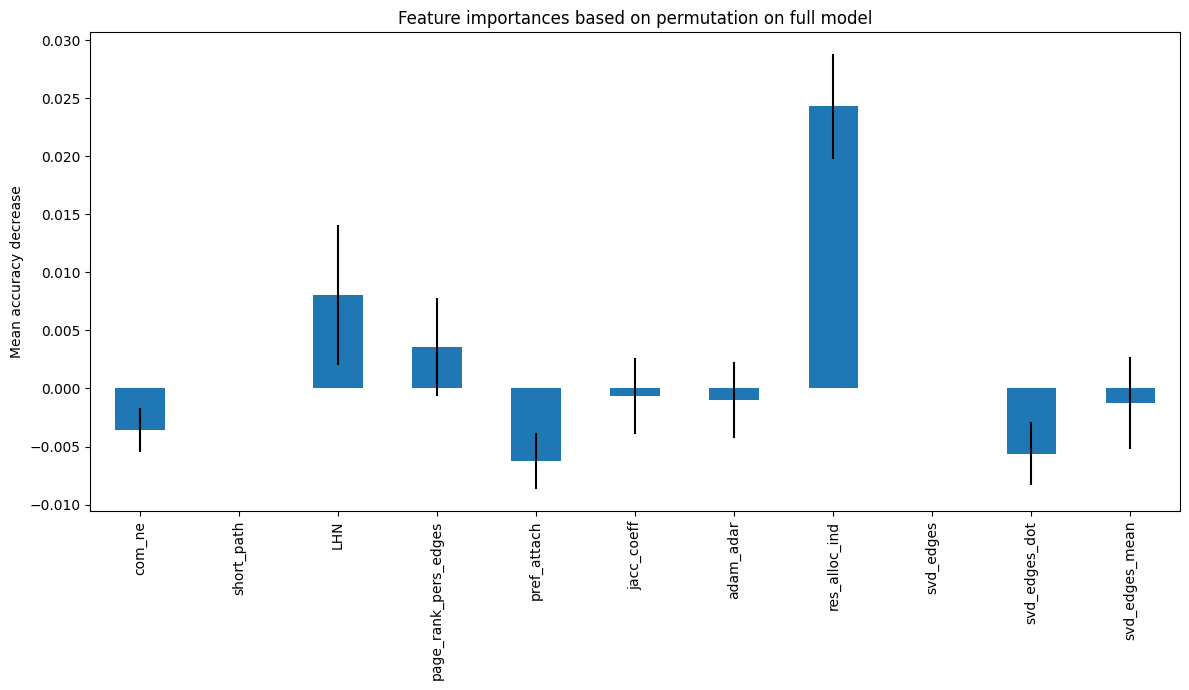

In [41]:
# random forest feature importance based on feature permutation

from sklearn.inspection import permutation_importance

result = permutation_importance(forest, link_prediction_test[feature_names],  link_prediction_test['goal'], n_repeats=10, random_state=seed, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
print('Feature importance based on mean accuracy decrease\n')
print(forest_importances.to_markdown())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances based on permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Step 4
## Quality class analisys

In [42]:
from bisect import bisect

def quality_class_label(error): 
    return bisect(quality_class_intervals, error) - 1

In [43]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba['quality_label'] = link_proba.apply(lambda row: quality_class_label(row['abs_error']), axis=1)
link_proba['quality_name'] = link_proba.apply(lambda row: quality_class_names[quality_class_label(row['abs_error'])], axis=1)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label,quality_name
0,20,22,0,0.039216,0.000000,0.013889,0.005039,0.024492,0.090909,0.847707,0.192857,6.661338e-16,3.921569e-02,1.666667e-01,0.00,0.00,0,exelent
1,160,247,0,0.000000,0.333333,0.000000,0.001361,0.125413,0.000000,0.000000,0.000000,1.873501e-16,6.071414e-15,-3.304388e-16,0.00,0.00,0,exelent
2,16,170,0,0.000000,0.333333,0.000000,0.000427,0.016675,0.000000,0.000000,0.000000,-3.955170e-16,6.442785e-15,-9.907199e-17,0.00,0.00,0,exelent
3,33,148,0,0.333333,0.000000,0.007463,0.005600,0.395171,0.202381,4.148473,0.283127,1.339207e-15,3.333333e-01,2.537313e-01,0.00,0.00,0,exelent
4,123,244,0,0.000000,0.666667,0.000000,0.000061,0.021365,0.000000,0.000000,0.000000,3.469447e-17,6.445416e-15,-2.931683e-16,0.24,0.24,0,exelent


In [44]:
# statistics on error
link_proba['abs_error'].describe()

count    786.000000
mean       0.164122
std        0.248429
min        0.000000
25%        0.000000
50%        0.040000
75%        0.217500
max        1.000000
Name: abs_error, dtype: float64

Text(0, 0.5, 'Number of node pairs')

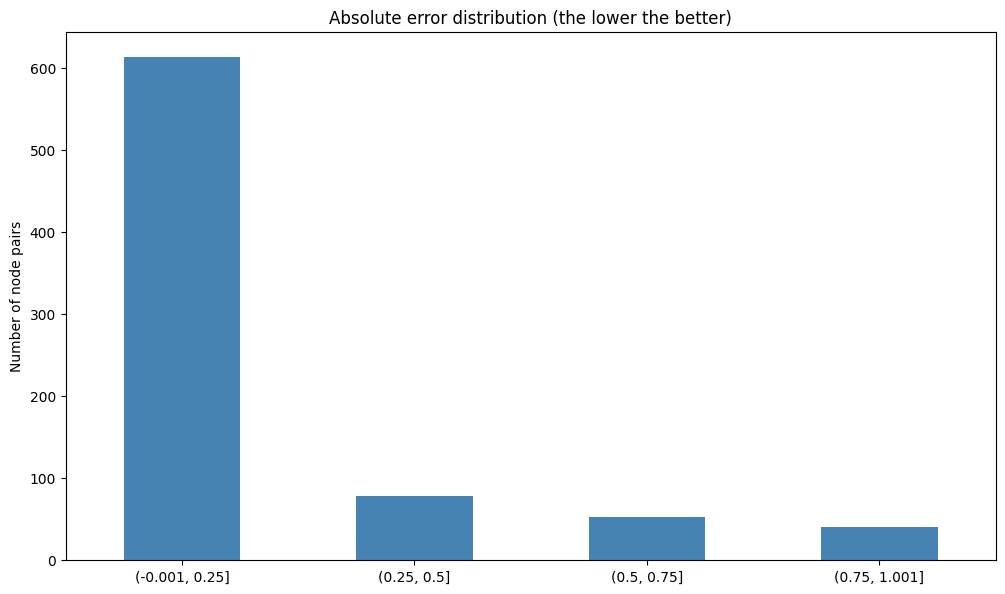

In [45]:
# plot error distribution
fig, ax = plt.subplots()

pd.cut(link_proba['abs_error'], bins=quality_class_intervals, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color='steelblue', ax=ax)
#ax.set_xticks(np.add(quality_class_labels, 0))
#ax.set_xticklabels(quality_class_names)
ax.set_title("Absolute error distribution (the lower the better)")
ax.set_ylabel("Number of node pairs")

# Step 5
## Quality class prediction

In [46]:
# train for quality class prediction

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=seed, class_weight='balanced')
clf.fit(link_proba[feature_names], link_proba['quality_label'])

/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=428)

In [47]:
# testing the classifier

proba = forest.predict_proba(classifier_test[feature_names])[:, 1]
proba = pd.Series(proba, name='prob')

classifier_test = classifier_test.join(prob)
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: quality_class_label(row['true_abs_error']), axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,true_abs_error,true_quality_label
0,177,230,0,0.117647,0.000000,0.004710,0.003613,0.220775,0.086957,1.565268,0.130639,-5.967449e-16,1.176471e-01,1.224490e-01,0.00,0.00,0
1,56,231,0,0.019608,0.000000,0.001520,0.002468,0.113775,0.016667,0.272958,0.025641,-1.568190e-15,1.960784e-02,2.127660e-02,0.00,0.00,0
2,109,167,0,0.196078,0.000000,0.009862,0.002334,0.175612,0.181818,2.470970,0.177209,-1.429412e-15,1.960784e-01,3.846154e-01,0.00,0.00,0
3,28,63,0,0.000000,0.666667,0.000000,0.000170,0.005558,0.000000,0.000000,0.000000,-2.012279e-16,6.509147e-15,6.002143e-17,0.00,0.00,0
4,63,198,0,0.000000,0.333333,0.000000,0.001891,0.015981,0.000000,0.000000,0.000000,-3.400058e-16,6.454597e-15,6.486953e-17,0.24,0.24,0


In [48]:
score = clf.score(classifier_test[feature_names], classifier_test['true_quality_label'])
print(f'Accuracy score on {len(classifier_test)} test samples is {score}')

Accuracy score on 786 test samples is 0.13358778625954199


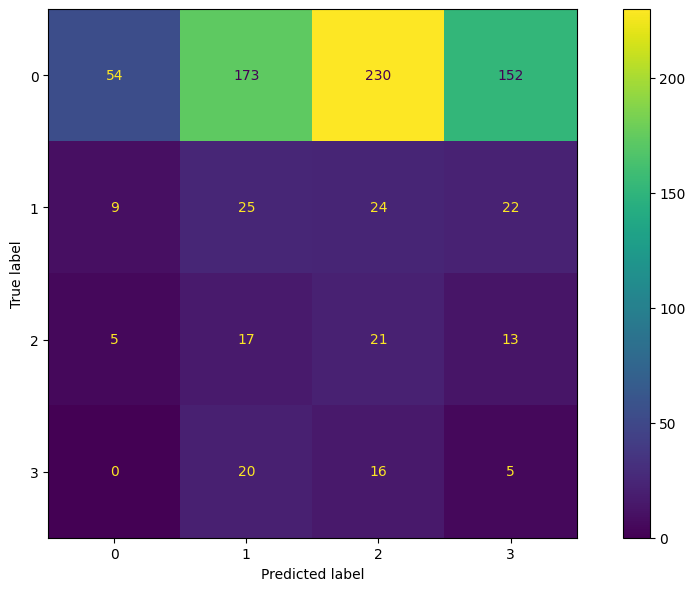

In [49]:
from sklearn import metrics

metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])